In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.palettes import all_palettes
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource, LinearColorMapper, BasicTicker, PrintfTickFormatter, ColorBar, GeoJSONDataSource
from bokeh.models.mappers import CategoricalColorMapper
from datetime import datetime
from math import *
import json

warnings.filterwarnings('ignore')

%matplotlib inline
%reload_ext autoreload
%autoreload 2

plt.style.use('ggplot')

output_notebook()

Loading BokehJS ...

In [2]:
sheet = [None] * 5
sheet

[None, None, None, None, None]

In [3]:
name = pd.ExcelFile('ABC-Company-Sales.xlsx').sheet_names

In [4]:
# tách ra 5 sheet từ file excel
with pd.ExcelFile('ABC-Company-Sales.xlsx') as f:
    for i in range(len(name)):
        sheet[i] = pd.read_excel(f, sheet_name=name[i])

In [5]:
# ghép 5 bảng với nhau
df = pd.merge(sheet[0], sheet[1])
for i in range(2, 5):
    df = pd.merge(df, sheet[i])

# sort lại data theo cột id
df = df.sort_values(by=['ID'])

# reset index
df = df.reset_index(drop=True)

df.SalesDate = df.SalesDate.apply(lambda x: x.date())

df['IsForeign'] = df.Country != 'Singapore'

In [6]:
df

,ID,SalesDate,OrderID,CustomerID,SalesPersonID,ProductID,Quantity,Sales,StoreID,Category,...,Latitude,Longitude,SalesPersonName,Title,Country,CustomerName,Gender,Phone,PostalCode,IsForeign
0,1,2015-01-01,10381,46,2,74,14,428.260000,8,Children's Clothes,...,1.30124,103.905230,Erik Presley,President,Singapore,Tony Montana,Female,(9) 331-6954,3508,False
1,2,2015-01-01,10382,19,3,5,32,179.840000,2,Men's Clothes,...,1.37974,103.764400,Rob Carsson,Sales Representative,UK,Greg Thatcher,Female,(171) 555-0297,WX1 6LT,True
2,3,2015-01-01,10382,19,3,18,9,241.020000,6,Baby Clothes,...,1.31101,103.796270,Rob Carsson,Sales Representative,UK,Greg Thatcher,Female,(171) 555-0297,WX1 6LT,True
3,4,2015-01-01,10382,19,3,29,14,1811.320000,2,Men's Footwear,...,1.37974,103.764400,Rob Carsson,Sales Representative,UK,Greg Thatcher,Female,(171) 555-0297,WX1 6LT,True
4,5,2015-01-01,10382,19,3,33,60,1649.400000,6,Sportswear,...,1.31101,103.796270,Rob Carsson,Sales Representative,UK,Greg Thatcher,Female,(171) 555-0297,WX1 6LT,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17027,17028,2017-12-12,15630,19,3,21,8,86.648383,3,Sportswear,...,1.39187,103.894820,Rob Carsson,Sales Representative,UK,Greg Thatcher,Female,(171) 555-0297,WX1 6LT,True
17028,17029,2017-12-12,15630,19,3,39,5,295.622144,3,Women's Clothes,...,1.39187,103.894820,Rob Carsson,Sales Representative,UK,Greg Thatcher,Female,(171) 555-0297,WX1 6LT,True
17029,17030,2017-12-12,15776,50,4,25,11,145.240185,6,Sportswear,...,1.31101,103.796270,Joan Callins,Sales Coordinator,Singapore,Marco Van Deum,Female,(02) 201 24 67,B-1180,False
17030,17031,2017-12-12,15776,50,4,27,37,1519.039036,6,Sportswear,...,1.31101,103.796270,Joan Callins,Sales Coordinator,Singapore,Marco Van Deum,Female,(02) 201 24 67,B-1180,False


In [7]:
df1 = df.groupby('SalesDate').sum().loc[:,['Quantity', 'Sales']].reset_index()
df1.head()

,SalesDate,Quantity,Sales
0,2015-01-01,5300,173878.513202
1,2015-01-02,6517,220697.136128
2,2015-01-03,1522,37603.717994
3,2015-01-04,99,5969.005562
4,2015-01-05,104,1617.189017


In [8]:
index_of_top_5_day = df1.sort_values(by='Quantity', ascending=False)[:5].index

In [9]:
# sources
source_circle = ColumnDataSource(pd.DataFrame(dict(
    SalesDate=[df1.loc[i][0] for i in index_of_top_5_day],
    Quantity=[df1.loc[i][1] for i in index_of_top_5_day]
)))

source_line = ColumnDataSource(df1)


from bokeh.models.transforms import LinearInterpolator

size_mapper = LinearInterpolator(
    x=[df1.Quantity.min(), df1.Quantity.max()],
    y=[1, 30]
)

TOOLS = 'save, pan, box_zoom, wheel_zoom, reset'

p = figure(
    x_axis_type='datetime', 
    plot_height=500,
    plot_width=800,
    tools=TOOLS,
)

p.line(x='SalesDate', y='Quantity', source=source_line, line_color='#747C92', line_width=3)
p.circle(
    x='SalesDate', 
    y='Quantity', 
    source=source_circle, 
    size={
        'field': 'Quantity',
        'transform': size_mapper
    },
    color='#3A2449'
)

p.add_tools(HoverTool(
    tooltips="<b>Date: </b> @SalesDate{%F} <br> <b>Quantities: </b> @Quantity",
    formatters={'@SalesDate': 'datetime'},
    mode='mouse'
))

p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Quantities'
p.title.text = 'Số lượng sản phẩm bán được theo ngày và top 5 ngày bán chạy nhất'
show(p)

In [240]:
# sources
source_circle = ColumnDataSource(pd.DataFrame(dict(
    SalesDate=[df1.loc[i][0] for i in index_of_top_5_day],
    Sales=[df1.loc[i][2] for i in index_of_top_5_day]
)))

source_line = ColumnDataSource(df1)


from bokeh.models.transforms import LinearInterpolator

size_mapper = LinearInterpolator(
    x=[df1.Sales.min(), df1.Sales.max()],
    y=[5, 17]
)

TOOLS = 'save, pan, box_zoom, wheel_zoom, reset'

p = figure(
    x_axis_type='datetime', 
    plot_height=220,
    plot_width=500,
    tools=TOOLS,
)


p.line(x='SalesDate', y='Sales', source=source_line, line_color='#726DA8', line_width=3)
p.circle(
    x='SalesDate', 
    y='Sales', 
    source=source_circle, 
    size={
        'field': 'Sales',
        'transform': size_mapper
    },
    color='#3E7CB1',
    name='circle'
)

p.add_tools(HoverTool(
    tooltips="<b>Date: </b> @SalesDate{%F} <br> <b>Sales: </b> @Sales{$ 0.00 a}",
    formatters={'@SalesDate': 'datetime'},
#     mode='mouse',
    names=['circle']
))

output_file('timeseries.html')

p.toolbar.autohide = True
p.title.text = 'Doanh thu theo ngày và top 5 ngày bán chạy nhất'
p.xgrid.visible = False
show(p)

- tháng 1 bán được nhiều

In [12]:
region_df = df.groupby(['Store', 'Latitude', 'Longitude', 'StoreID']).sum()[['Sales']].reset_index()

region_df['img'] = [
    'https://www.traveldailymedia.com/assets/2019/09/shutterstock_1160757373.png',
    'https://lifestyle2.prod.content.iproperty.com/news/wp-content/uploads/sites/2/2018/01/05164824/Bukit-Panjang-Plaza.jpg',
    'https://insideretail.asia/wp-content/uploads/2020/09/Compass-Point-2.jpg',
    'https://www.straitstimes.com/sites/default/files/articles/2018/04/10/nm-gwc-1004.jpg',
    'https://www.hdb.gov.sg/cs/infoweb/-/media/HDBContent/Images/PLG/bannerhdbhub.jpg',
    'https://www.toursingapore.net.vn/images/dia-diem/Holland-Village-6.jpg',
    'https://www.todayonline.com/sites/default/files/styles/new_app_article_detail/public/photos/43_images/20201019_jurong_point_google_maps.jpg?itok=gPl2mMV1',
    'https://owa.bestprice.vn/images/destinations/uploads/marina-square-5ea661685750e.jpg',
    'https://media-cdn.tripadvisor.com/media/photo-s/07/bf/02/41/parkway-parade.jpg'
]

In [13]:
region_df

,Store,Latitude,Longitude,StoreID,Sales,img
0,Airport Terminal 1,1.35732,103.987309,7,1.443581e+06,https://www.traveldailymedia.com/assets/2019/0...
1,Bukit Panjang Plaza,1.37974,103.764400,2,1.736684e+06,https://lifestyle2.prod.content.iproperty.com/...
2,Compass Point,1.39187,103.894820,3,1.605814e+06,https://insideretail.asia/wp-content/uploads/2...
3,Great World City,1.29266,103.832490,5,1.203205e+06,https://www.straitstimes.com/sites/default/fil...
4,HDB Hub,1.33239,103.848133,4,1.392243e+06,https://www.hdb.gov.sg/cs/infoweb/-/media/HDBC...
5,Holland Village,1.31101,103.796270,6,2.312533e+06,https://www.toursingapore.net.vn/images/dia-di...
6,Jurong Point,1.34032,103.706006,1,2.432999e+06,https://www.todayonline.com/sites/default/file...
7,Marina Square,1.29136,103.857860,9,1.057786e+06,https://owa.bestprice.vn/images/destinations/u...
8,Parkway Parade,1.30124,103.905230,8,1.064502e+06,https://media-cdn.tripadvisor.com/media/photo-...


In [14]:
all_palettes['YlGn'][8]

('#005a32',
 '#238443',
 '#41ab5d',
 '#78c679',
 '#addd8e',
 '#d9f0a3',
 '#f7fcb9',
 '#ffffe5')

In [15]:
f = open('singapore.geojson', 'r')
singapore_geojson = f.read()

In [16]:
data = json.loads(singapore_geojson)

In [17]:
geo_source = GeoJSONDataSource(geojson=json.dumps(data))

In [18]:
data

{'type': 'GeometryCollection',
 'geometries': [{'type': 'MultiPolygon',
   'coordinates': [[[[103.5666666, 1.1955],
      [103.5765837, 1.2546559],
      [103.6028611, 1.2641667],
      [103.6084966, 1.285403],
      [103.6161667, 1.3143056],
      [103.6176676, 1.3174348],
      [103.6178333, 1.3216111],
      [103.6268528, 1.3379472],
      [103.6304669, 1.344009],
      [103.6331044, 1.3504685],
      [103.6332024, 1.3506631],
      [103.6332481, 1.3507535],
      [103.6332834, 1.3508234],
      [103.6358857, 1.3551693],
      [103.6408889, 1.3629722],
      [103.6462477, 1.3740191],
      [103.6492554, 1.3799147],
      [103.6529721, 1.3870832],
      [103.6534999, 1.3912777],
      [103.6571666, 1.4004166],
      [103.6639166, 1.4104721],
      [103.6694443, 1.4157499],
      [103.6738888, 1.4281388],
      [103.6833332, 1.4372499],
      [103.6939716, 1.4399876],
      [103.6989283, 1.443291],
      [103.7037499, 1.4507777],
      [103.714111, 1.4574721],
      [103.7283332, 1.46

In [19]:
import bokeh.sampledata
bokeh.sampledata.download()

Using data directory: C:\Users\nvatu\.bokeh\data
Skipping 'CGM.csv' (checksum match)
Skipping 'US_Counties.zip' (checksum match)
Skipping 'us_cities.json' (checksum match)
Skipping 'unemployment09.csv' (checksum match)
Skipping 'AAPL.csv' (checksum match)
Skipping 'FB.csv' (checksum match)
Skipping 'GOOG.csv' (checksum match)
Skipping 'IBM.csv' (checksum match)
Skipping 'MSFT.csv' (checksum match)
Skipping 'WPP2012_SA_DB03_POPULATION_QUINQUENNIAL.zip' (checksum match)
Skipping 'gapminder_fertility.csv' (checksum match)
Skipping 'gapminder_population.csv' (checksum match)
Skipping 'gapminder_life_expectancy.csv' (checksum match)
Skipping 'gapminder_regions.csv' (checksum match)
Skipping 'world_cities.zip' (checksum match)
Skipping 'airports.json' (checksum match)
Skipping 'movies.db.zip' (checksum match)
Skipping 'airports.csv' (checksum match)
Skipping 'routes.csv' (checksum match)
Skipping 'haarcascade_frontalface_default.xml' (checksum match)


In [20]:
# from bokeh.models import LogColorMapper
# from bokeh.palettes import Viridis6 as palette
# from bokeh.sampledata.unemployment import data as unemployment
# from bokeh.sampledata.us_counties import data as counties

# palette = tuple(reversed(palette))

# counties = {
#     code: county for code,
#     county in counties.items() if county["state"] == "tx"
# }

# county_xs = [county["lons"] for county in counties.values()]
# county_ys = [county["lats"] for county in counties.values()]

# county_names = [county['name'] for county in counties.values()]
# county_rates = [unemployment[county_id] for county_id in counties]
# color_mapper = LogColorMapper(palette=palette)

# data=dict(
#     x=county_xs,
#     y=county_ys,
#     name=county_names,
#     rate=county_rates,
# )

# TOOLS = "pan,wheel_zoom,reset,hover,save"

# p = figure(
#     title="Texas Unemployment, 2009", tools=TOOLS,
#     x_axis_location=None, y_axis_location=None,
#     tooltips=[
#         ("Name", "@name"), ("Unemployment rate", "@rate%"), ("(Long, Lat)", "($x, $y)")
#     ])
# p.grid.grid_line_color = None
# p.hover.point_policy = "follow_mouse"

# p.patches('x', 'y', source=data,
#           fill_color={'field': 'rate', 'transform': color_mapper},
#           fill_alpha=0.7, line_color="white", line_width=0.5)

# show(p)

In [21]:
region_df

,Store,Latitude,Longitude,StoreID,Sales,img
0,Airport Terminal 1,1.35732,103.987309,7,1.443581e+06,https://www.traveldailymedia.com/assets/2019/0...
1,Bukit Panjang Plaza,1.37974,103.764400,2,1.736684e+06,https://lifestyle2.prod.content.iproperty.com/...
2,Compass Point,1.39187,103.894820,3,1.605814e+06,https://insideretail.asia/wp-content/uploads/2...
3,Great World City,1.29266,103.832490,5,1.203205e+06,https://www.straitstimes.com/sites/default/fil...
4,HDB Hub,1.33239,103.848133,4,1.392243e+06,https://www.hdb.gov.sg/cs/infoweb/-/media/HDBC...
5,Holland Village,1.31101,103.796270,6,2.312533e+06,https://www.toursingapore.net.vn/images/dia-di...
6,Jurong Point,1.34032,103.706006,1,2.432999e+06,https://www.todayonline.com/sites/default/file...
7,Marina Square,1.29136,103.857860,9,1.057786e+06,https://owa.bestprice.vn/images/destinations/u...
8,Parkway Parade,1.30124,103.905230,8,1.064502e+06,https://media-cdn.tripadvisor.com/media/photo-...


In [22]:
p = figure(plot_height=400, plot_width=700, title='Region Sales')

region_src = ColumnDataSource(region_df)

size_mapper = LinearInterpolator(
    x=[region_df.Sales.min(), region_df.Sales.max()],
    y=[10, 50]
)

color_mapper = CategoricalColorMapper(
    palette=all_palettes['Colorblind'][8],
    factors=region_df.Store
)

p.circle(
    x='Longitude',
    y='Latitude',
    source=region_src,
    size={
        'field': 'Sales',
        'transform': size_mapper
    },
    color={
        'field': 'Store',
        'transform': color_mapper
    },
    alpha=0.7
)

p.add_tools(HoverTool(
    tooltips="""
        <div style="padding: 3px;border-radius:5px;border:2px solid gray;">
            <div id="left" style="display:flex; width:200px; height:auto; border: 2px solid gray; border-radius:5px;">
                <img src="@img" style="border-radius:4px; width:200px;"></img>
            </div>
            <div id="right" style="display:flex; width:auto; height:auto;">
                <div style="margin: 0 auto;">
                    <div><b>Location:</b> @Store</div>
                    <div><b>Sales:</b> @Sales{$ 0,0.000}</div>
                </div>
            </div>
        </div>
    """
))

show(p)

In [23]:
category_df = sheet[1].groupby('Category').count()

In [24]:
category_df['Category'] = category_df.index
category_df.index = np.arange(len(category_df))

In [25]:
category_df.drop(['ProductID'], axis=1, inplace=True)

In [26]:
category_df

,Product,Category
0,11,Baby Clothes
1,4,Children's Clothes
2,8,Men's Clothes
3,7,Men's Footwear
4,18,Sportswear
5,6,Swimwear
6,16,Women's Clothes
7,7,Women's Footwear


<BarContainer object of 8 artists>

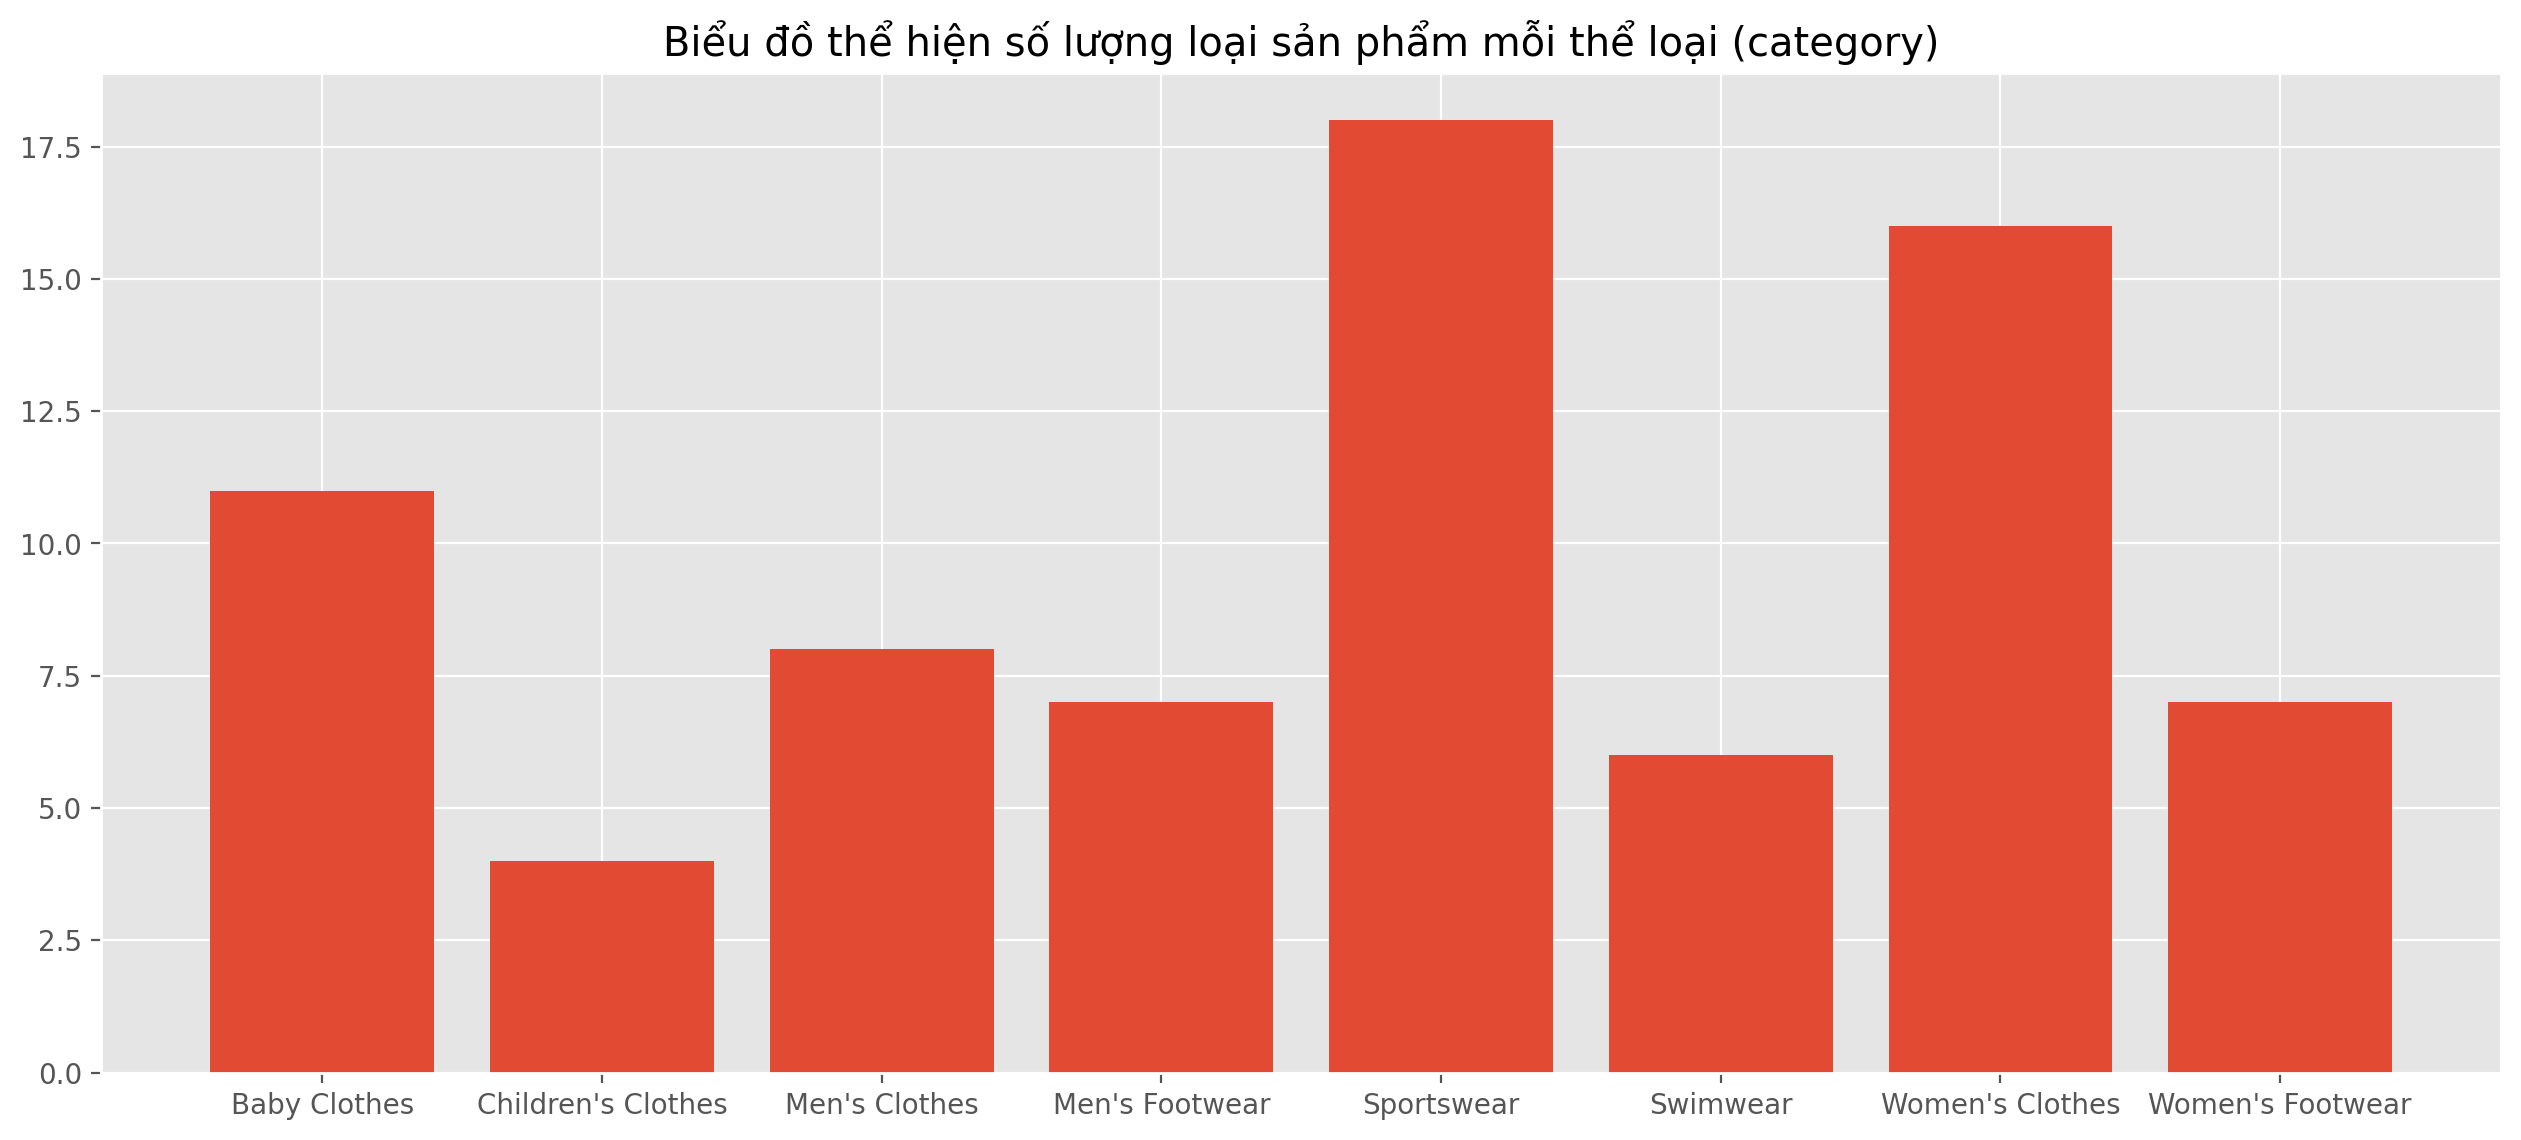

In [27]:
fig = plt.figure(figsize=(12, 5), dpi=200)
axes = fig.add_axes([0, 0, 1, 1])
axes.set_title('Biểu đồ thể hiện số lượng loại sản phẩm mỗi thể loại (category)')
axes.bar(category_df['Category'], category_df['Product'])

In [28]:
sum_sales = dict()
for i in sheet[0][['SalesPersonID', 'Sales']].values:
    d = int(i[0])
    sum_sales[d] = i[1] if (d not in sum_sales) else sum_sales[d] + i[1]

In [29]:
sum_sales

{2: 555591.5018339675,
 3: 2797928.154334477,
 8: 2052004.0863422889,
 4: 785896.8317440161,
 6: 927555.7374766337,
 5: 674124.5399937062,
 7: 2189768.7788493335,
 1: 2162628.840851628,
 9: 2103847.3319120524}

In [30]:
sum_sales.items()

dict_items([(2, 555591.5018339675), (3, 2797928.154334477), (8, 2052004.0863422889), (4, 785896.8317440161), (6, 927555.7374766337), (5, 674124.5399937062), (7, 2189768.7788493335), (1, 2162628.840851628), (9, 2103847.3319120524)])

In [31]:
sheet[3]

,SalesPersonID,SalesPersonName,Title
0,1,Frank Roll,Sales Representative
1,2,Erik Presley,President
2,3,Rob Carsson,Sales Representative
3,4,Joan Callins,Sales Coordinator
4,5,Ingrid Hendrix,Sales Representative
5,6,Lennart Skoglund,Sales Representative
6,7,Tom Lindwall,Sales Representative
7,8,Leif Shine,Sales Manager
8,9,Helen Brolin,Sales Representative


In [32]:
sheet[3][sheet[3]['SalesPersonID'] == 6]['SalesPersonName'][5]

'Lennart Skoglund'

In [33]:
sum_sales = {sheet[3][sheet[3]['SalesPersonID'] == i]['SalesPersonName'][i - 1] : j for i, j in sum_sales.items()}

In [34]:
sum_sales

{'Erik Presley': 555591.5018339675,
 'Rob Carsson': 2797928.154334477,
 'Leif Shine': 2052004.0863422889,
 'Joan Callins': 785896.8317440161,
 'Lennart Skoglund': 927555.7374766337,
 'Ingrid Hendrix': 674124.5399937062,
 'Tom Lindwall': 2189768.7788493335,
 'Frank Roll': 2162628.840851628,
 'Helen Brolin': 2103847.3319120524}

In [35]:
sum_sales_df = pd.DataFrame(sum_sales.items())
sum_sales_df

,0,1
0,Erik Presley,5.555915e+05
1,Rob Carsson,2.797928e+06
2,Leif Shine,2.052004e+06
3,Joan Callins,7.858968e+05
4,Lennart Skoglund,9.275557e+05
5,Ingrid Hendrix,6.741245e+05
6,Tom Lindwall,2.189769e+06
7,Frank Roll,2.162629e+06
8,Helen Brolin,2.103847e+06


In [36]:
sum_sales_df

,0,1
0,Erik Presley,5.555915e+05
1,Rob Carsson,2.797928e+06
2,Leif Shine,2.052004e+06
3,Joan Callins,7.858968e+05
4,Lennart Skoglund,9.275557e+05
5,Ingrid Hendrix,6.741245e+05
6,Tom Lindwall,2.189769e+06
7,Frank Roll,2.162629e+06
8,Helen Brolin,2.103847e+06


In [37]:
sum_sales_df.columns = ['SalesPersonName', 'Sales']

In [38]:
sum_sales_df

,SalesPersonName,Sales
0,Erik Presley,5.555915e+05
1,Rob Carsson,2.797928e+06
2,Leif Shine,2.052004e+06
3,Joan Callins,7.858968e+05
4,Lennart Skoglund,9.275557e+05
5,Ingrid Hendrix,6.741245e+05
6,Tom Lindwall,2.189769e+06
7,Frank Roll,2.162629e+06
8,Helen Brolin,2.103847e+06


In [39]:
sum_sales_df

,SalesPersonName,Sales
0,Erik Presley,5.555915e+05
1,Rob Carsson,2.797928e+06
2,Leif Shine,2.052004e+06
3,Joan Callins,7.858968e+05
4,Lennart Skoglund,9.275557e+05
5,Ingrid Hendrix,6.741245e+05
6,Tom Lindwall,2.189769e+06
7,Frank Roll,2.162629e+06
8,Helen Brolin,2.103847e+06


In [40]:
import seaborn as sns

In [41]:
sns.set(rc={'figure.figsize':(20, 10)})
sns.set_context("paper", font_scale=1.7)  

Text(0.5, 1.0, 'Doanh số bán hàng của từng nhân viên')

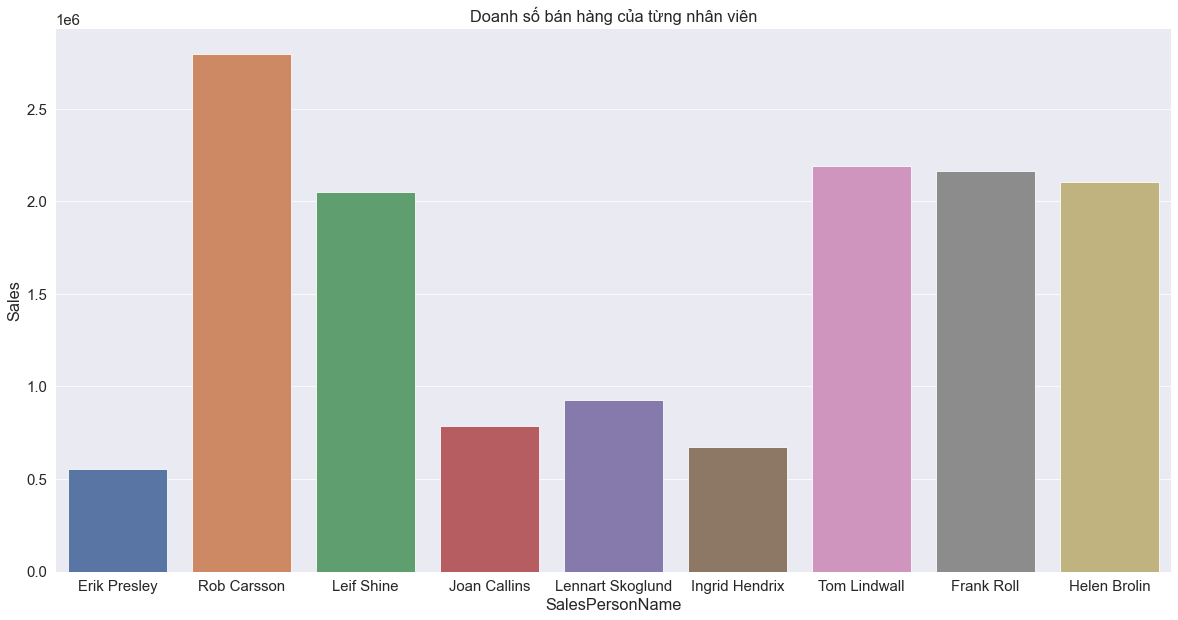

In [42]:
sns.barplot(data=sum_sales_df,x='SalesPersonName', y='Sales').set_title('Doanh số bán hàng của từng nhân viên')

In [43]:
sheet[2].iloc[:, 1] = sheet[2].iloc[:, 1].str.strip()

In [44]:
sheet[2]

,StoreID,Region,Store,Latitude,Longitude
0,1,West,Jurong Point,1.34032,103.706006
1,2,West,Bukit Panjang Plaza,1.37974,103.764400
2,3,North,Compass Point,1.39187,103.894820
3,4,Central,HDB Hub,1.33239,103.848133
4,5,South,Great World City,1.29266,103.832490
5,6,South,Holland Village,1.31101,103.796270
6,7,East,Airport Terminal 1,1.35732,103.987309
7,8,East,Parkway Parade,1.30124,103.905230
8,9,South,Marina Square,1.29136,103.857860


In [45]:
sheet[2][sheet[2].Region == 'West']

,StoreID,Region,Store,Latitude,Longitude
0,1,West,Jurong Point,1.34032,103.706006
1,2,West,Bukit Panjang Plaza,1.37974,103.764400


In [46]:
sheet[0]

,ID,SalesDate,OrderID,CustomerID,SalesPersonID,ProductID,Quantity,Sales,StoreID
0,1,2015-01-01,10381,46,2,74,14,428.260000,8
1,2,2015-01-01,10382,19,3,5,32,179.840000,2
2,3,2015-01-01,10382,19,3,18,9,241.020000,6
3,4,2015-01-01,10382,19,3,29,14,1811.320000,2
4,5,2015-01-01,10382,19,3,33,60,1649.400000,6
...,...,...,...,...,...,...,...,...,...
17027,17028,2017-12-12,15630,19,3,21,8,86.648383,3
17028,17029,2017-12-12,15630,19,3,39,5,295.622144,3
17029,17030,2017-12-12,15776,50,4,25,11,145.240185,6
17030,17031,2017-12-12,15776,50,4,27,37,1519.039036,6


In [47]:
sales_store_id = sheet[0].groupby('StoreID').sum()[['Sales']]

In [48]:
sales_store_id

,Sales
StoreID,
1,2.432999e+06
2,1.736684e+06
3,1.605814e+06
4,1.392243e+06
5,1.203205e+06
6,2.312533e+06
7,1.443581e+06
8,1.064502e+06
9,1.057786e+06


In [49]:
sales_store_id['StoreID'] = sales_store_id.index
sales_store_id.index = np.arange(len(sales_store_id))

In [50]:
sales_store_id

,Sales,StoreID
0,2.432999e+06,1
1,1.736684e+06,2
2,1.605814e+06,3
3,1.392243e+06,4
4,1.203205e+06,5
5,2.312533e+06,6
6,1.443581e+06,7
7,1.064502e+06,8
8,1.057786e+06,9


In [51]:
sales_store_id['Sales'].sum()

14249345.80333811

In [52]:
sum_store_sales = sales_store_id.values.T[0].sum()
sum_store_sales

14249345.80333811

In [53]:
sales_store_id.values

array([[2.43299936e+06, 1.00000000e+00],
       [1.73668407e+06, 2.00000000e+00],
       [1.60581354e+06, 3.00000000e+00],
       [1.39224251e+06, 4.00000000e+00],
       [1.20320517e+06, 5.00000000e+00],
       [2.31253309e+06, 6.00000000e+00],
       [1.44358057e+06, 7.00000000e+00],
       [1.06450183e+06, 8.00000000e+00],
       [1.05778566e+06, 9.00000000e+00]])

In [54]:
sales_store_id.to_dict()['Sales']

{0: 2432999.3617772553,
 1: 1736684.0748675743,
 2: 1605813.5394695112,
 3: 1392242.5094300061,
 4: 1203205.1700777253,
 5: 2312533.0915847346,
 6: 1443580.567335565,
 7: 1064501.8335758855,
 8: 1057785.655219853}

In [55]:
region_sales = {}
for i,j in sales_store_id.values:
    d = sheet[2][sheet[2].StoreID == int(j)]['Region'].values[0]
    if d in region_sales:
        region_sales[d] += i
    else: region_sales[d] = i
region_sales

{'West': 4169683.43664483,
 'North': 1605813.5394695112,
 'Central': 1392242.5094300061,
 'South': 4573523.916882313,
 'East': 2508082.4009114504}

In [56]:
sum(region_sales.values())

14249345.80333811

In [57]:
region_sales_percent = {}
for i,j in region_sales.items():
    region_sales_percent[i] = (j / sum_store_sales) * 100
region_sales_percent

{'West': 29.262279785981633,
 'North': 11.269384304599631,
 'Central': 9.77057142583945,
 'South': 32.09637817766273,
 'East': 17.60138630591656}

In [58]:
dic = pd.DataFrame(region_sales_percent.items())
dic.columns = ['Region', 'SalesPercent']

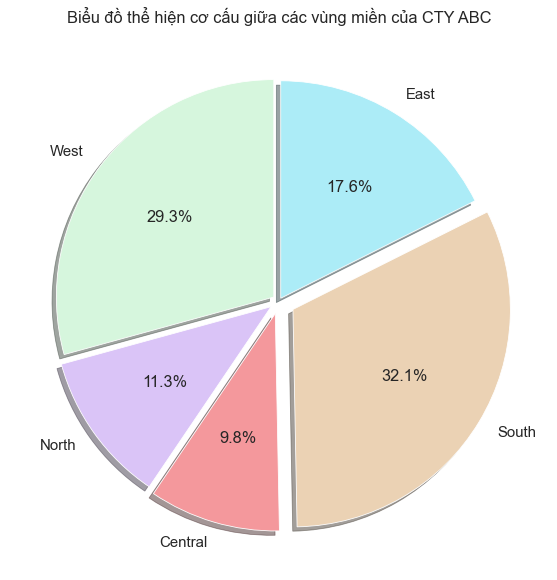

In [224]:
my_colors = ['#D6F6DD','#DAC4F7','#F4989C','#EBD2B4','#ACECF7'] 
plt.pie(dic['SalesPercent'], labels=dic['Region'], autopct = '%1.1f%%', shadow=True,
        startangle=90, explode=(0.03, 0.045, 0.06, 0.075, 0.015),colors = my_colors)
plt.title("Biểu đồ thể hiện cơ cấu giữa các vùng miền của CTY ABC")

plt.savefig('pie.png')

plt.show()

In [60]:
regions_product_sales = sheet[0].groupby('StoreID').count()[['ProductID']]

In [61]:
regions_product_sales

,ProductID
StoreID,
1,2839
2,2088
3,1930
4,1665
5,1439
6,2797
7,1663
8,1191
9,1420


In [62]:
sheet[1][['ProductID', 'Category']].values

array([[10, 'Baby Clothes'],
       [13, 'Baby Clothes'],
       [18, 'Baby Clothes'],
       [30, 'Baby Clothes'],
       [36, 'Baby Clothes'],
       [37, 'Baby Clothes'],
       [40, 'Baby Clothes'],
       [41, 'Baby Clothes'],
       [46, 'Baby Clothes'],
       [58, 'Baby Clothes'],
       [73, 'Baby Clothes'],
       [7, "Children's Clothes"],
       [14, "Children's Clothes"],
       [28, "Children's Clothes"],
       [74, "Children's Clothes"],
       [1, "Men's Clothes"],
       [5, "Men's Clothes"],
       [11, "Men's Clothes"],
       [24, "Men's Clothes"],
       [31, "Men's Clothes"],
       [70, "Men's Clothes"],
       [71, "Men's Clothes"],
       [75, "Men's Clothes"],
       [9, "Men's Footwear"],
       [17, "Men's Footwear"],
       [29, "Men's Footwear"],
       [45, "Men's Footwear"],
       [47, "Men's Footwear"],
       [48, "Men's Footwear"],
       [51, "Men's Footwear"],
       [2, 'Sportswear'],
       [16, 'Sportswear'],
       [19, 'Sportswear'],
       [

In [63]:
map_regions = dict()
for i, j in sheet[2][['StoreID', 'Region']].values:
    map_regions[i] = j
map_regions

{1: 'West',
 2: 'West',
 3: 'North',
 4: 'Central',
 5: 'South',
 6: 'South',
 7: 'East',
 8: 'East',
 9: 'South'}

In [64]:
map_category = dict()
for i, j in sheet[1][['ProductID', 'Category']].values:
    map_category[i] = j
map_category

{10: 'Baby Clothes',
 13: 'Baby Clothes',
 18: 'Baby Clothes',
 30: 'Baby Clothes',
 36: 'Baby Clothes',
 37: 'Baby Clothes',
 40: 'Baby Clothes',
 41: 'Baby Clothes',
 46: 'Baby Clothes',
 58: 'Baby Clothes',
 73: 'Baby Clothes',
 7: "Children's Clothes",
 14: "Children's Clothes",
 28: "Children's Clothes",
 74: "Children's Clothes",
 1: "Men's Clothes",
 5: "Men's Clothes",
 11: "Men's Clothes",
 24: "Men's Clothes",
 31: "Men's Clothes",
 70: "Men's Clothes",
 71: "Men's Clothes",
 75: "Men's Clothes",
 9: "Men's Footwear",
 17: "Men's Footwear",
 29: "Men's Footwear",
 45: "Men's Footwear",
 47: "Men's Footwear",
 48: "Men's Footwear",
 51: "Men's Footwear",
 2: 'Sportswear',
 16: 'Sportswear',
 19: 'Sportswear',
 20: 'Sportswear',
 21: 'Sportswear',
 25: 'Sportswear',
 26: 'Sportswear',
 27: 'Sportswear',
 33: 'Sportswear',
 49: 'Sportswear',
 54: 'Sportswear',
 55: 'Sportswear',
 59: 'Sportswear',
 60: 'Sportswear',
 61: 'Sportswear',
 62: 'Sportswear',
 68: 'Sportswear',
 69: '

In [65]:
sheet[0]

,ID,SalesDate,OrderID,CustomerID,SalesPersonID,ProductID,Quantity,Sales,StoreID
0,1,2015-01-01,10381,46,2,74,14,428.260000,8
1,2,2015-01-01,10382,19,3,5,32,179.840000,2
2,3,2015-01-01,10382,19,3,18,9,241.020000,6
3,4,2015-01-01,10382,19,3,29,14,1811.320000,2
4,5,2015-01-01,10382,19,3,33,60,1649.400000,6
...,...,...,...,...,...,...,...,...,...
17027,17028,2017-12-12,15630,19,3,21,8,86.648383,3
17028,17029,2017-12-12,15630,19,3,39,5,295.622144,3
17029,17030,2017-12-12,15776,50,4,25,11,145.240185,6
17030,17031,2017-12-12,15776,50,4,27,37,1519.039036,6


In [66]:
map_quantity_regions = dict()
map_sale_regions = dict()
for i, j, k, l in sheet[0][['ProductID', 'Quantity', 'Sales', 'StoreID']].values:
    if map_regions[l] not in map_quantity_regions:
        map_quantity_regions[map_regions[l]] = dict()
    if map_category[i] in map_quantity_regions[map_regions[l]]:
        map_quantity_regions[map_regions[l]][map_category[i]] += j
    else: map_quantity_regions[map_regions[l]][map_category[i]] = j

In [67]:
map_quantity_regions['West']

{"Men's Clothes": 19599.0,
 "Men's Footwear": 9089.0,
 "Women's Clothes": 20974.0,
 'Sportswear': 34881.0,
 'Baby Clothes': 17723.0,
 "Women's Footwear": 11004.0,
 "Children's Clothes": 5054.0,
 'Swimwear': 6528.0}

In [68]:
dat = pd.DataFrame(map_quantity_regions['West'].items())

In [69]:
dat.columns = ['Category', 'Quantity']

In [70]:
dat

,Category,Quantity
0,Men's Clothes,19599.0
1,Men's Footwear,9089.0
2,Women's Clothes,20974.0
3,Sportswear,34881.0
4,Baby Clothes,17723.0
5,Women's Footwear,11004.0
6,Children's Clothes,5054.0
7,Swimwear,6528.0


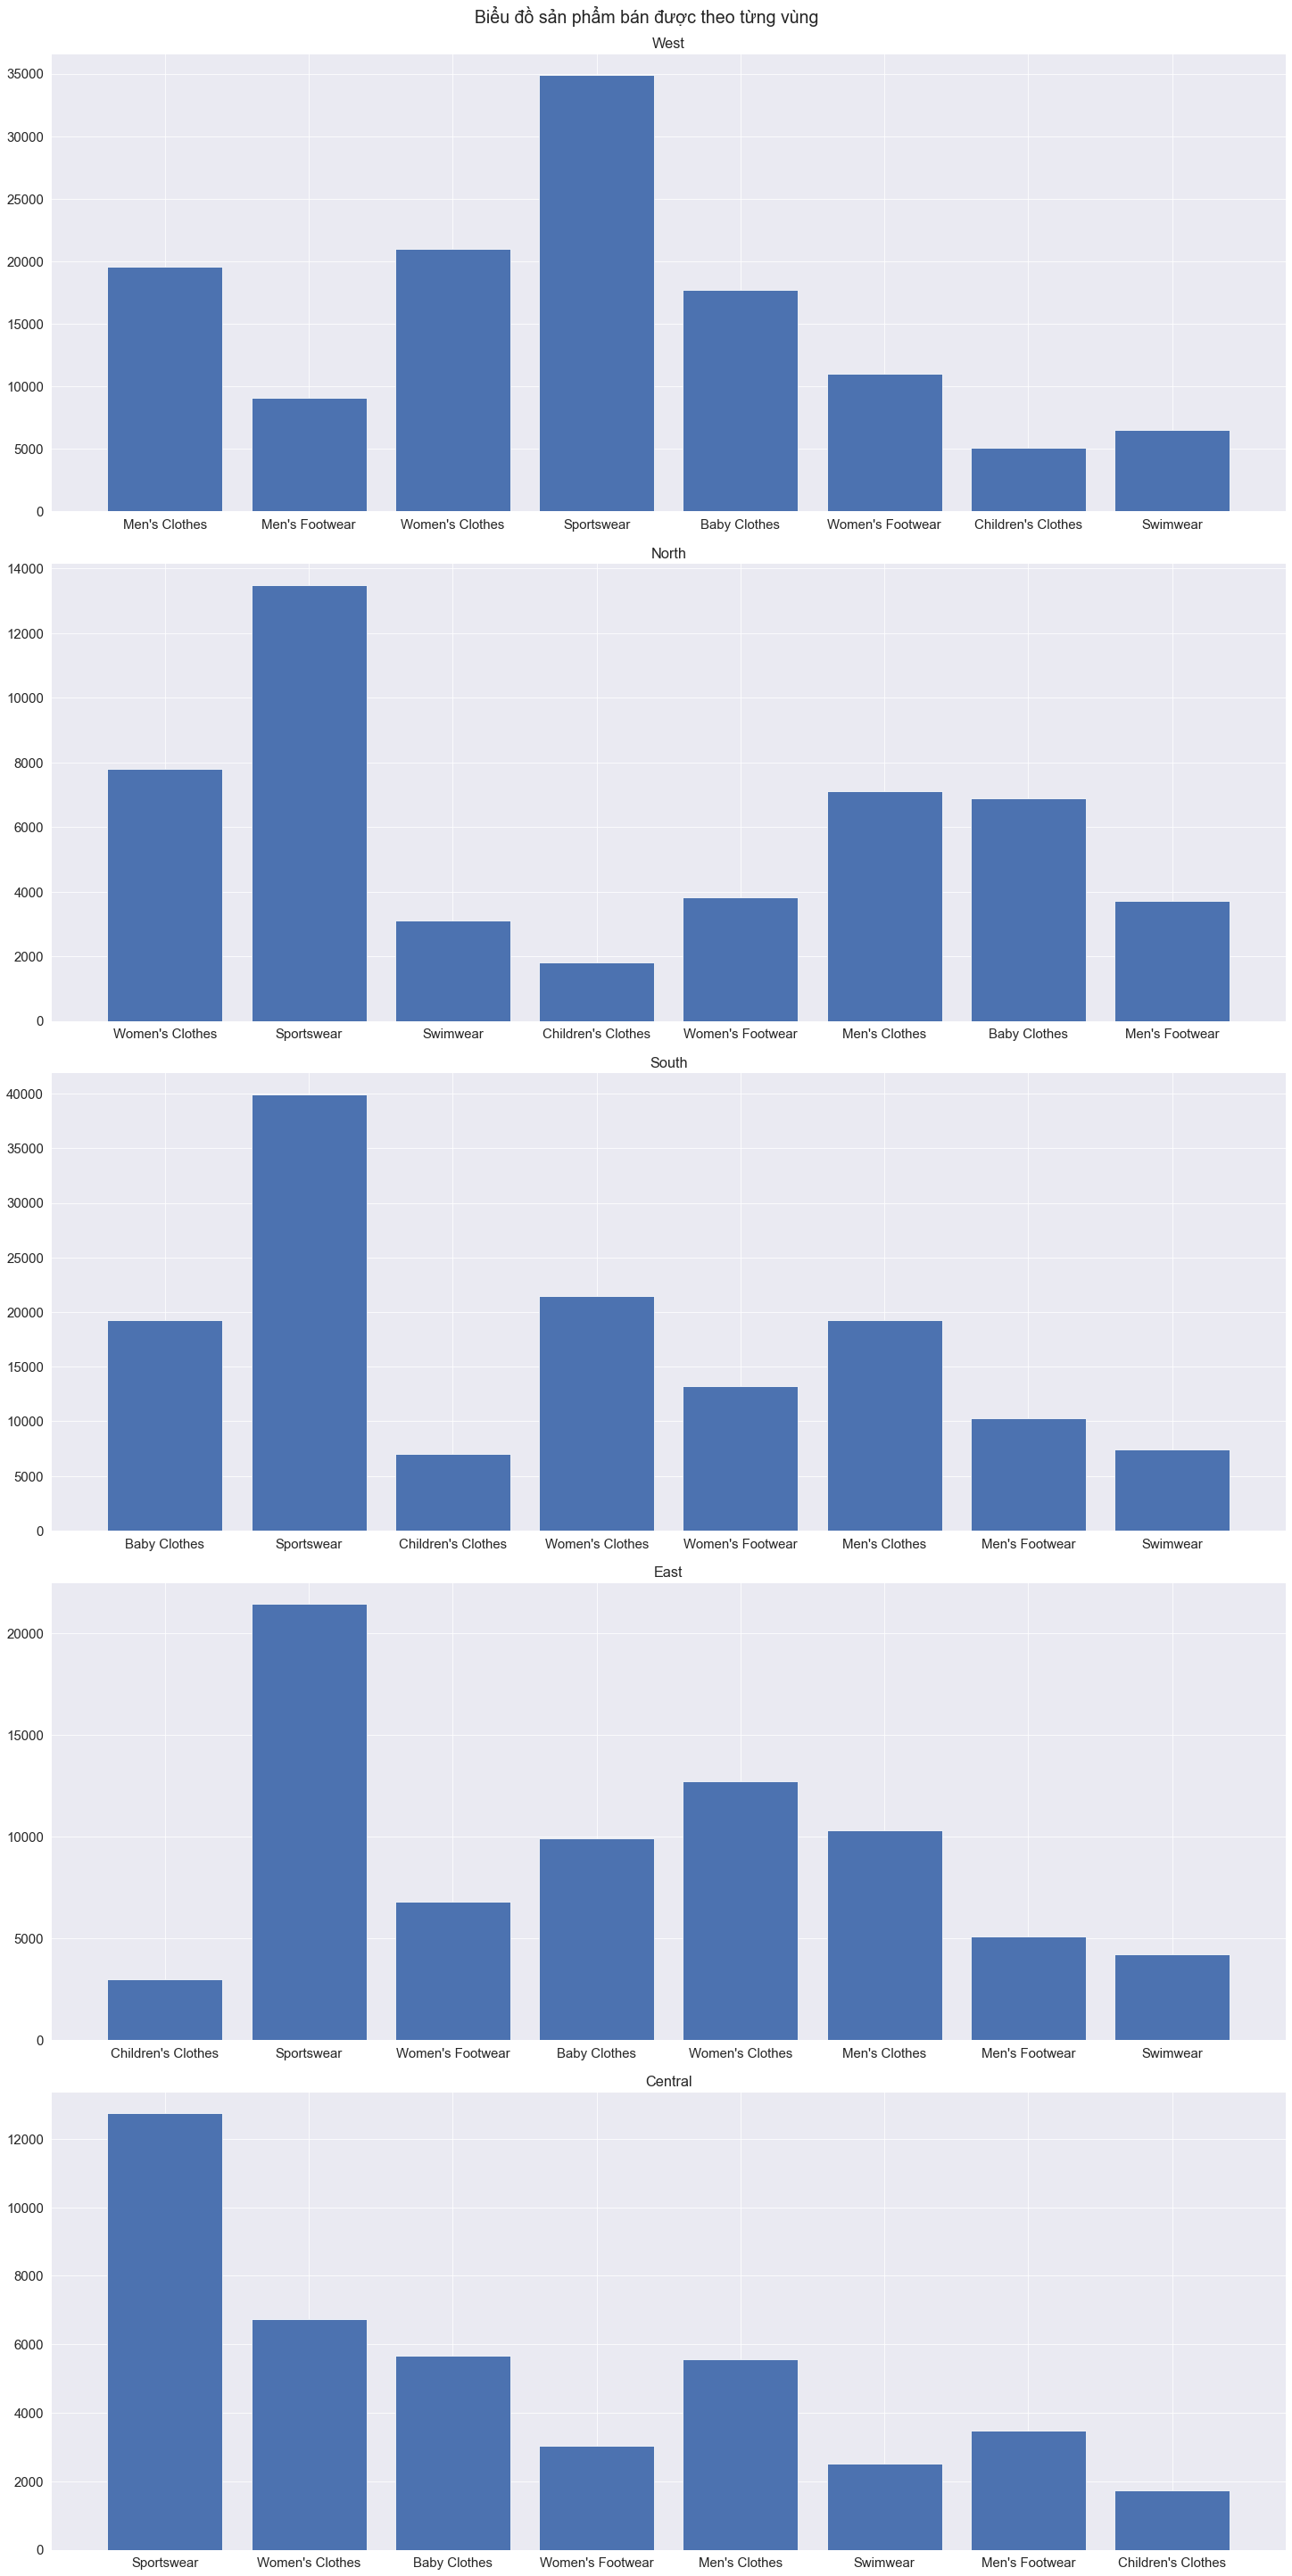

In [71]:
fig, a = plt.subplots(5, 1, figsize = (20, 40), constrained_layout=True)
a[0].bar(map_quantity_regions['West'].keys(), map_quantity_regions['West'].values())
a[0].set_title('West')
a[1].bar(map_quantity_regions['North'].keys(), map_quantity_regions['North'].values())
a[1].set_title('North')
a[2].bar(map_quantity_regions['South'].keys(), map_quantity_regions['South'].values())
a[2].set_title('South')
a[3].bar(map_quantity_regions['East'].keys(), map_quantity_regions['East'].values())
a[3].set_title('East')
a[4].bar(map_quantity_regions['Central'].keys(), map_quantity_regions['Central'].values())
a[4].set_title('Central')
fig.suptitle("Biểu đồ sản phẩm bán được theo từng vùng")
plt.show()

In [72]:
df2 = df.groupby('Category').sum()[['Quantity']].reset_index().sort_values(by='Quantity', ascending=False)

src = ColumnDataSource(df2)

p = figure(x_range=df2.Category, plot_width=900, plot_height=400)

p.vbar(x='Category', top='Quantity', source=src, color='cyan', width=0.7)
labels = LabelSet(x='Category', y='Quantity', text='Quantity', level='glyph', text_align='center',
        x_offset=-5, y_offset=0, source=src, render_mode='canvas')
p.add_layout(labels)

show(p)

In [237]:
from bokeh.transform import factor_cmap

sum_sales_df = df.groupby(['SalesPersonName', 'Title']).sum()[['Sales']].reset_index()
sum_sales_df.Sales = sum_sales_df.Sales.apply(lambda x: ceil(x))
sum_sales_df['color'] = all_palettes['Paired'][9]
src = ColumnDataSource(sum_sales_df)
color_mapper = CategoricalColorMapper(palette=all_palettes['Paired'][9])

p = figure(x_range=sum_sales_df['SalesPersonName'], plot_height=300, plot_width = 400, 
#            title="Doanh số bán hàng của từng nhân viên",
           toolbar_location=None)

# labels = LabelSet(x='SalesPersonName', y='Sales', text='Sales', level='glyph', text_align='center',
#         x_offset=0, y_offset=0, source=src, render_mode='canvas', text_font_size="5pt")

p.vbar(x='SalesPersonName', top='Sales', source=src, 
       width=0.75,
       line_color='white', fill_color=factor_cmap('SalesPersonName', palette=all_palettes['Paired'][9], factors=sum_sales_df['SalesPersonName'])
)

p.add_tools(HoverTool(
    tooltips="""
        <div>
            <b>Name: </b>@SalesPersonName <br>
            <b>Title: </b>@Title <br>
            <b>Sales: </b>@Sales{$ 0,000}
        </div>
    """
))

output_file('sales_employee.html')

p.xaxis.major_label_orientation = 0.5
p.xgrid.visible = False

p.title.text = 'Tổng doanh thu của nhân viên'
    
show(p)

- dash board:
    - biểu đồ time series: (sổ ra)
        + trong nước
        + nước ngoài
        + cả 2

- cột ghép/chồng, đường thể hiện, khách in out, trung bình của (trong, ngoài)
- biểu đồ time series thể hiện doanh thu của khách nước ngoài

In [255]:
from bokeh.models import FactorRange, NumeralTickFormatter
from bokeh.transform import dodge

sales_df = df.groupby(['Region', 'IsForeign']).sum()[['Sales']].reset_index()
sales_df.Sales = sales_df.Sales.apply(lambda x: ceil(x))
sales_df = sales_df.sort_values(by=['Sales'])

foreign = ['Foreign', 'Domestic']
region = sales_df.Region.unique()
foreign_sales=sales_df[sales_df.IsForeign == True].Sales
domestic_sales=sales_df[sales_df.IsForeign == False].Sales
mean = (np.asarray(foreign_sales) + np.asarray(domestic_sales)) / 2
mean = mean.astype('int64')

x = [(i, j) for i in region for j in foreign]
x_sales = sum(zip(foreign_sales, domestic_sales), ())

src = ColumnDataSource(data=dict(
    x=x,
    mean=mean,
    region=region,
    x_sales=x_sales,
    foreign_sales=foreign_sales,
    domestic_sales=domestic_sales,
    color=['#55DDE0', '#33658A'] * 5
))

muted_color='#f0f2f0'

p = figure(x_range=FactorRange(*x), plot_height=220, plot_width=500)

p.vbar(x='x', top='x_sales', source=src, width=0.95, color='color', legend_label="Sales", muted_color=muted_color)

# mean
col = '#2F4858'
p.line(x=region, y=mean, color=col, legend_label='Aver Sales', name='line', muted_color=muted_color, line_width=1)
p.circle(x=region, y=mean, size=8, color=col, legend_label='Aver Sales', name='circle', muted_color=muted_color)

labels = LabelSet(x='x', y='x_sales', text='x_sales', source=src, x_offset=6, y_offset=-1, text_align='center',
                 render_mode='css', level='glyph', text_font_size="8pt")

p.add_layout(labels)

p.add_tools(HoverTool(
    tooltips="""
        <b>Aver Sales:</b> @y{$ 0}
    """,
    names=['circle']
))

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None
p.legend.location = "top_left"
p.legend.click_policy = "mute"
p.legend.orientation = "horizontal"
p.toolbar.autohide = True
p.title.text = 'Doanh thu khách trong nước và ngoài nước của 5 khu vực'

output_file('line_bar.html')

show(p)